#Trabajo Practico N° 2
Grupo: Factorización LR - Azul Barracchia & Augusto Guarnaccio

## Importamos librerías y datos

Primero importamos todo aquello que se usara para el presente TP.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

Ahor importamos los datos con los que vamos a trabajar.

In [ ]:
df_wine = pd.read_csv('./wine.csv')

Y chequeamos que se hayan importado correctamente.

In [ ]:
df_wine.head()

## Declaramos funciones
En este apartado declararemos todas las funciones que son necesarias para llevar adelante el trabajo.
En primer lugar, realizamos una función que dado un dataframe y el nombre de una columna calcule el promedio de dicha columna.

In [ ]:
def promedio(df, nombre_columna):
    avg = 0
    for i in df[nombre_columna]:
       avg += i
    avg /= df.shape[0]
    return avg

En segundo lugar, realizamos una función que dado un dataframe y el nombre de una columna calcule el desvío estándar de dicha columna.

In [ ]:
def desvio_estandar(df, nombre_columna):
    std = 0
    avg = promedio(df, nombre_columna)
    for i in df[nombre_columna]:
        std += (i - avg) ** 2
    std *= 1/(df.shape[0] - 1)
    std = np.sqrt(std)
    return std

En tercer lugar, realizamos una función que dado un dataframe y el nombre de una columna, normaliza y centra sus datos.

In [ ]:
def centrar_normalizar(df, nombre_columna):
    avg = promedio(df, nombre_columna)
    std = desvio_estandar(df, nombre_columna)
    nuevosValores = []
    for i in df[nombre_columna]:
        Xi = i
        nuevosValores.append((Xi-avg)/std)
    df[nombre_columna] = nuevosValores

En cuarto lugar, realizamos una función que dado una lista de vectores convierta esa lista en matriz.

In [ ]:
def transformarAMatriz(avects):
    avects = np.array(avects)
    W = np.zeros((len(avects),len(avects[0])))
    for i in range(len(avects)):
        W[i] = avects[i].reshape(len(avects[0]))
    return np.transpose(W)

En quinto lugar, realizamos una función que dados dos vectores calcule su distancia en norma 2.

In [ ]:
def distDosVec(v,w):
    return np.linalg.norm(v-w,2)

En sexto lugar, realizamos una matriz que dados dos arrays calcula la matriz de confusión.

In [ ]:
def calcularMatrizConfusión(Y_test,Y_pred):
    confusion = np.zeros((3,3))
    for j in range(len(Y_test)):
       if Y_test[j] == 1:
         if 1 == Y_pred[j]:
           confusion[0,0] += 1
         elif Y_pred[j] == 2:
            confusion[0,1] += 1
         else:
            confusion[0,2] += 1
       elif Y_test[j] == 2:
         if 2 == Y_pred[j]:
           confusion[1,1] += 1
         elif Y_pred[j] == 1:
            confusion[1,0] += 1
         else:
            confusion[1,2] += 1
       else:
         if 3 == Y_pred[j]:
           confusion[2,2] += 1
         elif Y_pred[j] == 1:
            confusion[2,0] += 1
         else:
            confusion[2,1] += 1
    return confusion

En séptimo lugar, realizamos una función que dada una matriz de confusión nos devuelve la accuracy del método.

In [ ]:
def calcularAccuracy(matriz):
    cantidadTotal = 0
    valoresBienClas = 0
    for i in range(matriz.shape[0]):
      valoresBienClas += matriz[i,i]
      for j in range(matriz.shape[0]):
        cantidadTotal += matriz[i,j]
    acc = valoresBienClas/cantidadTotal
    return acc

Declaramos una clave que luego usaremos para ordenar una lista de tuplas

In [ ]:
def claveParaOrdenar(tupla):
  return (tupla[0], -tupla[1])

## Ejercicio 1
### Normalizamos y centramos los datos

Para esta tarea usaremos las fórmulas y los procesos especificados en las instrucciones.
En primer lugar, separamos en variables dependientes (Y) e independientes (X).

In [ ]:
variable_dependiente = 'Customer_Segment'
Y = df_wine[[variable_dependiente]]
Xs = df_wine.drop(columns=variable_dependiente)

Normalizamos y centramos los datos. Este es un paso importante a realizar previo a trabajar con cualquier conjunto de datos. Veamos por qué.

En primer lugar, es importante centrar los datos ya que con este paso desplazamos la nuve de datos al origen lo que luego nos permite manipular los datos con una mayor facilidad.
En segundo lugar, es importante normalizar los datos (aunque no siempre es necesario) ya que puedo tener variables que tengan órdenes de magnitud muy diferentes entre sí lo que va a causar que la varianza de variables con valores altos sea mayor que las variables cuyo órden de magnitud no es tan grande lo que capaz no refleja lo que en verdad está sucediendo; además, de que la primera componente principal va a ser cercana a esta dirección, lo que quizás tampoco refleja lo que verdaderamente está sucediendo. Para evitar este fenómeno es que normalizamos.


In [ ]:
atributosXs = Xs.columns.values
for i in range(13):
    centrar_normalizar(Xs, atributosXs[i])

### Armamos la matriz de covarianza

Ahora que tenemos los datos dispuestos de esta manera, podemos armar la matriz de covarianza; matriz que en cada una de sus coordenadas representa la covarianza de dos características/atributos de nuestra base de datos. Es una matriz cuadrada simétrica cuya dimensión es $cantidad$  $de$ $caracteristicas$ x $cantidad$ $de$ $caracteristicas$.

A su vez, si decidimos normalizar los datos la matriz tendrá $1$s en la diagonal y en el resto de sus posiciones números mayormente en el intervalo $[-1, 1]$
 (aunque en algunos casos pueden no estar en este rango).

Por ejemplo, si la llamamos $C$ entonces en $C[0,0]$ vamos a encontrar la covarianza de la característica 1 consigmo misma, es decir, la varianza. En cambio en $C[0,1]$ vamos a encontrar la covarianza de la característica 1 con la característica 2.

En el caso de este trabajo, es una matriz de dimensión $13$x$13$ que representa la varianza y la covarianza de las diferentes características de los vinos.


In [ ]:
def calculoCov(df):
    prom = np.mean(df, axis=0).values
    PROM = np.tile(prom.reshape((len(prom), 1)), df.shape[0])
    PROM = np.transpose(PROM)
    B = df.values
    B = B - PROM
    Mcov = np.dot(B.T,B)/ 178
    return Mcov

Mostramos la matriz de covarianza. Vale aclarar que por una cuestión de representación de los números asociada a Python en la diagonal no tenemos $1$s sino valores muy cercanos.

In [ ]:
print(calculoCov(Xs))

### Implementamos el método de la potencia
Ahora implementaremos el método de la potencia para poder despejar el máximo autovalor y su autovector asociado. Esta función nos será de utilidad ya que luego con esta podremos despejar los autovalores y los autovectores asociados de la matriz de covarianza.

In [ ]:
def metodo_de_la_potencia(A):
    # Tomamos un vector cualquiera no nulo
    avect = np.random.rand(A.shape[0])
    k = 9999
    for _ in range(k):
        avect = (A @ avect) / np.linalg.norm(A @ avect,2)
        aval = (np.transpose(avect) @ A @ avect) / (np.transpose(avect) @ avect)
    return aval, avect

Probemos la función para que devuela el autovalor y autovector máximo de nuestra matriz de covarianza.

In [ ]:
A = calculoCov(Xs)
max_aval_cov = metodo_de_la_potencia(A)[0]
avect_asoc_cov = metodo_de_la_potencia(A)[1]
print('Aval máximo: ', max_aval_cov,
      '\nAvect asociado : ', avect_asoc_cov)

#### Modificamos la función
Como anticipamos, ahora modificaremos la función anteriormente declarada para poder calcular todos los autovalores y todos los autovectores. Para ello, usaremos el algoritmo de deflación.

Esta función que implementamos, recibe una matriz simétrica A (decidimos considerarla simétrica ya que solo usaremos esta función aplicada sobre matrices de covarianza) y una cantidad n (menor a su cantidad de filas) y devuelve los n autovalores de módulo máximo y sus correspondientes autovectores.

In [ ]:
def metodo_de_la_potencia_2(A,n):
    # Tomamos un vector cualquiera no nulo
    avect = np.random.rand(A.shape[0])
    avect = np.reshape(avect, (A.shape[0], 1))
    avects = []
    avals = []
    k = 9999
    for _ in range(n):
        for _ in range(k):
            avect = (A @ avect) / np.linalg.norm(A @ avect,2)
            aval = (np.transpose(avect) @ A @ avect) / (np.transpose(avect) @ avect)
        avects.append(avect)
        avals.append(aval[0][0])
        A = A - (aval * (avect @ np.transpose(avect)))
    avects = transformarAMatriz(avects)
    return avals, avects

In [ ]:
A = calculoCov(Xs)
max_avals_cov = metodo_de_la_potencia_2(A,13)[0]
avects_asoc_cov = metodo_de_la_potencia_2(A,13)[1]
print('Aval máximo: ', max_avals_cov,
      '\nAvect asociado : ', avects_asoc_cov)

### Despejamos autovalores y autovectores

Con la función modificada en el apartado anterior despejaremos los autovalores y autovectores de la matriz de covarianza. Estos son importantes y están fuertemente relacionados con la matriz que almacena nuestros datos.

Por un lado, la matriz de covarianza va a tener 1 autovalor por cada característica que tengan nuestros vinos, es decir, la cantidad de autovalores va a ser la misma que la cantidad de propiedades de los vecinos. Por lo tanto, va a ser una matriz diagonalizable. A su vez, estos 13 autovalores van a ser los 13 valores singulares de la descomposición SVD de la matriz que almacena nuestros datos.

Por otro lado, los autovectores van a representar las componentes principales de nuestra matriz que almacena los datos. Si ordenamos los autovalores de mayor a menor vamos a tener ordenadas de mayor a menor las diferentes componentes principales, donde la mayor representa la dirección de mayor variabilidad de nuestros datos.




### PCA

El próximo paso, y el penúltimo antes de poder realizar los experimentos será implementar la función que nos permita hacer el análisis en componentes principales. Para esto, seguimos los pasos explicitados en el documento de cálculos auxiliares. La función definida toma un dataframe, lo convierte en matriz y calcula la proyección de la matriz en el espacio generado por los autovectores pasados como parámetros.

In [ ]:
def metodoDePCA(X, avects):
    X = X.values
    W = avects
    return X @ W

Probemos la función para 4 autovectores.

In [ ]:
print(metodoDePCA(Xs, metodo_de_la_potencia_2(calculoCov(Xs),4)[1]))

### kNN



El último paso antes de realizar los experimentos será implementar una función que realice el algoritmo kNN.


In [ ]:
def kNN(X_train,Y_train,X_test,k,n, avects):
    # Calculamos la proyección de los datos de train con el PCA
    X_data = metodoDePCA(X_train, avects)

    # Pasamos a matriz todo lo que sea df
    Y_data = Y_train.values[:,0]
    X_pred = X_test.values
    # Centramos y estandarizamos los datos de test
    for i in range(X_pred.shape[1]):
      X_pred[:, i] = (X_pred[:, i] - promedios[i])/desvios_estandares[i]

    # Proyectamos
    X_pred = X_pred @ avects
    Y_pred = np.zeros(X_pred.shape[0])

    labels = Y_train['Customer_Segment'].unique().tolist()

    for i in range(X_pred.shape[0]):
        k_vecinos = []
        for j in range(X_data.shape[0]):
            dist = distDosVec(X_pred[i], X_data[j])
            label = Y_data[j]
            k_vecinos.append((dist,label))
        # Ordenamos la lista de menor a mayor para obtener los que más cerca están
        k_vecinos = sorted(k_vecinos, key=claveParaOrdenar)
        k_vecinos = k_vecinos[:k]
        # Nos quedamos con los k vecinos
        segundos_elementos = [tupla[1] for tupla in k_vecinos]
        # Ahora armamos una nueva lista solo con los labels para saber cuál es el que más se repite
        repeticionesLabels = [segundos_elementos.count(labels[0]), segundos_elementos.count(labels[1]), segundos_elementos.count(labels[2])]
        Y_pred[i] = labels[repeticionesLabels.index(max(repeticionesLabels))]
        # Nos quedamos con el de mayor repeticiones

    return Y_pred

## Ejercicio 2



Ahora, comenzaremos a resolver la segunda parte del trabajo, donde pondremos a prueba nuestro método PCA. Para esto primero dividiremos nuestro dataframe en uno de train o entrenamiento y en otro de testeo o prueba.

In [ ]:
variable_dependiente = 'Customer_Segment'
Y = df_wine[[variable_dependiente]]
Xs = df_wine.drop(columns=variable_dependiente)
X_train, X_test, Y_train, Y_test = train_test_split(Xs, Y, test_size= 0.20, random_state=5, stratify=Y)

Centralizamos y normalizamos los datos de train.

In [ ]:
atributosX_train = X_train.columns.values
promedios = []
desvios_estandares = []
for i in range(13):
    promedios.append(promedio(X_train, atributosX_train[i]))
    desvios_estandares.append(desvio_estandar(X_train, atributosX_train[i]))
    centrar_normalizar(X_train, atributosX_train[i])

Ahora, evaluaremos el sistema de recomendación usando 1, 2, 3 y 4 componentes principales. Los valores que vayamos a obtener serán almacenados en la siguiente tabla.

In [ ]:
TABLA = pd.DataFrame(columns= ['Modelo PCA', 'Componente', 'Varianza explicada', 'Porcentaje %', 'Acumulado %'])

j = 0
Mcov = calculoCov(X_train)
avals_cov = metodo_de_la_potencia_2(Mcov,13)[0]
suma = sum(avals_cov)
for i in range(1,5):

    if i == 1:
        TABLA.at[j,'Modelo PCA'] = '1 Componente Principal'
        TABLA.at[j, 'Componente'] = 1
        varianzaExplicada = avals_cov[0] / suma
        TABLA.at[j, 'Varianza explicada'] = varianzaExplicada
        TABLA.at[j, 'Porcentaje %'] = varianzaExplicada * 100
        TABLA.at[j, 'Acumulado %'] = varianzaExplicada * 100
        j += 1

    else:
        varianzasExplicadas = []
        for k in range(1,i+1):
            varianzasExplicadas.append(avals_cov[k-1] / suma)
            TABLA.at[j,'Modelo PCA'] = f'{i} Componentes Principales'
            TABLA.at[j, 'Componente'] = k
            TABLA.at[j, 'Varianza explicada'] = varianzasExplicadas[k-1]
            TABLA.at[j, 'Porcentaje %'] = varianzasExplicadas[k-1] * 100
            acumulado = sum(varianzasExplicadas)
            TABLA.at[j, 'Acumulado %'] = acumulado * 100
            j += 1

La tabla resultante es la siguiente.

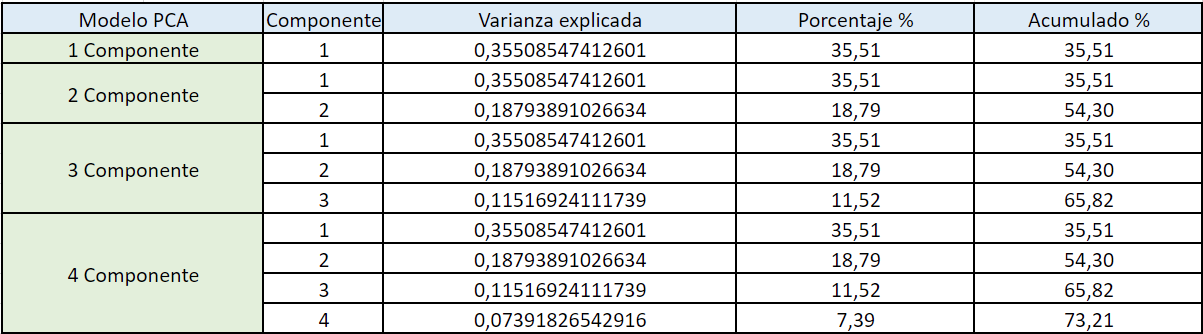

### Gráficos


Ahora que tenemos las tablas, vamos a graficar como se verían las proyecciones y los resultados obtenidos para ver si podemos encontrar una tendencia o elegir un mejor método.

Para eso primero nos quedamos con las 3 labels de todos los vinos.

In [ ]:
labels = Y_train['Customer_Segment'].unique().tolist()

Ahora, para cada una de las componentes graficaremos la proyección separando en colores las labels.

In [ ]:
X1 = metodoDePCA(X_train, metodo_de_la_potencia_2(calculoCov(X_train),1)[1])
X1 = np.append(X1, Y_train.values, 1) # Agregamos las labels a los datos para poder graficar

plt.title("Proyección en la primera componente principal")
for label in labels:
    X = X1[X1[:, 1] == label]
    plt.scatter(x=X[:, 0], y=np.zeros(X.shape[0]), label=f'Customer_segment {int(label)}')
plt.xlabel('u1')
plt.legend()
plt.show()

In [ ]:
X2 = metodoDePCA(X_train, metodo_de_la_potencia_2(calculoCov(X_train),2)[1])
X2 = np.append(X2, Y_train.values, 1) # Agregamos las labels a los datos para poder graficar

plt.title("Proyección en las dos primeras componentes principales")
for label in labels:
    X = X2[X2[:, 2] == label]
    plt.scatter(x=X[:, 0], y=X[:, 1], label=f'Customer_segment {int(label)}')
plt.xlabel('u1')
plt.ylabel('u2')
plt.legend()
plt.show()

In [ ]:
X3 = metodoDePCA(X_train, metodo_de_la_potencia_2(calculoCov(X_train),3)[1])
X3 = np.append(X3, Y_train.values, 1) # Agregamos las labels a los datos para poder graficar

plt.title("Proyección en las tres primeras componentes principales")
ax = plt.axes(projection='3d')
for label in labels:
    X = X3[X3[:, 3] == label]
    ax.scatter3D(xs=X[:,0], ys=X[:,1], zs=X[:,2], label=f'Customer_segment {int(label)}')
##plt.xslabel('u1')
##plt.yslabel('u2')
##plt.zslabel('u3')
plt.legend()
plt.show()

### Métricas

Ahora llega la hora de testear qué tan bueno es nuestro sistema de recomendación. Para eso, para cada una de las 4 componentes principales calcularemos la matriz de confusión.

In [ ]:
avects = metodo_de_la_potencia_2(calculoCov(X_train),4)[1]
Y_pred = kNN(X_train, Y_train, X_test, 1, 1, avects[:,:1])

matrixcf1 = calcularMatrizConfusión(Y_test.values[:,0], Y_pred)

sns.heatmap(matrixcf1, annot=True, cbar = False).set(title='Matriz de confusion para k = 1 y 1 componente principal', xlabel = 'Valor predicho', ylabel = 'Valor real')

In [ ]:
Y_pred = kNN(X_train, Y_train, X_test, 1, 2, avects[:,:2])

matrixcf2 = calcularMatrizConfusión(Y_test.values[:,0], Y_pred)

sns.heatmap(matrixcf2, annot=True, cbar = False).set(title='Matriz de confusion para k = 1 y 2 componentes principales', xlabel = 'Valor predicho', ylabel = 'Valor real')


In [ ]:
Y_pred = kNN(X_train, Y_train, X_test, 1, 3, avects[:,:3])

matrixcf3 = calcularMatrizConfusión(Y_test.values[:,0], Y_pred)

sns.heatmap(matrixcf3, annot=True, cbar = False).set(title='Matriz de confusion para k = 1 y 3 componentes principales', xlabel = 'Valor predicho', ylabel = 'Valor real')

In [ ]:
Y_pred = kNN(X_train, Y_train, X_test, 1, 4, avects)

matrixcf4 = calcularMatrizConfusión(Y_test.values[:,0], Y_pred)

sns.heatmap(matrixcf4, annot=True, cbar = False).set(title='Matriz de confusion para k = 1 y 4 componentes principales', xlabel = 'Valor predicho', ylabel = 'Valor real')

Ahora que tenemos todas las matrices de confusión podemos calcular los accuracies de cada uno de los métodos de arriba.

In [ ]:
TABLA = pd.DataFrame(columns= ['Cantidad componentes', 'Accuracy %'])
almacenarCF = [matrixcf1, matrixcf2, matrixcf3, matrixcf4]
for i in range(1,5):
  TABLA.at[i, 'Cantidad componentes'] = i
  TABLA.at[i, 'Accuracy %'] = calcularAccuracy(almacenarCF[i-1])*100

print(TABLA)

  Cantidad componentes Accuracy %
1                    1  77.777778
2                    2  94.444444
3                    3  88.888889
4                    4  94.444444


No obstante, estos datos no nos resultaron suficientes y quisimos ver qué pasa cuándo cambiamos los vecinos para poder decantarnos por el mejor modelo. Para ello, realizamos el siguiente experimento para ver cómo cambia la efectividad del modelo de predicción para distintas cantidades de vecinos, y distintas cantidades de componentes principales.

In [ ]:
accuraciesTodos = []
for cantComponentes in range(1,5):
  accuracies = []
  for k in range(1,11):
    Y_pred = kNN(X_train, Y_train, X_test, k, cantComponentes, avects[:,:cantComponentes])
    Mconfusion = calcularMatrizConfusión(Y_test.values[:,0], Y_pred)
    accuracies.append(calcularAccuracy(Mconfusion))
  accuraciesTodos.append(accuracies)

plt.plot(np.arange(1,11), accuraciesTodos[0], label = '1 componente principal', alpha=0.7)
plt.plot(np.arange(1,11), accuraciesTodos[1], label = '2 componentes principales', alpha=0.7)
plt.plot(np.arange(1,11), accuraciesTodos[2], label = '3 componentes principales', alpha=0.7)
plt.plot(np.arange(1,11), accuraciesTodos[3], label = '4 componentes principales', alpha=0.7)
plt.legend()
plt.title('Accuracy del modelo de knn para distintas cantidades de componentes y de vecinos')
plt.xlabel('Cantidad de vecinos')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1,11))
plt.ylim(0.70,1.00)


Se puede ver que para k = 1, los valores de accuracy para 4 y 2 componentes son los mismos, esta información también se puede ver en la tabla previamente presentada. Nos sorprendió que esto pasara, ya que esperabamos que con 3 componentes principales la predicción sea del mismo nivel o mejor que para 2 componentes. Creemos que una posible razón de esto es la proyección que realizamos con el método PCA. Esta debe generar valores numéricos muy cercanos por lo que a la hora de calcular la distancia de un nuevo vino no funciona con la precisión suficiente. De todos modos, con este gráfico podemos ver que para más cantidad de vecinos esto sí se cumple.

Otra información que nos brinda el gráfico es el momento en que para cada componente principal se alcanza la máxima accuracy. Por ejemplo, si se quiere utilizar el kNN para 4 componentes principales y generar la mayor accuracy posible bastaría con elegir k = 2.

## Conclusión

Son varias las conclusiones a las que llegamos con el presente trabajo cuyo objetivo fue el análisis de la habilidad de predicción del modelo de KNN que implementamos mediante la medición de su accuracy.

En primer lugar, a partir del gráfico, donde se compara los distintos modelos variando la cantidad de componentes principales y la cantidad de vecinos, se puede concluir que el modelo mejora significativamente si se elige más de 1 de autovector para proyectar los valores. Es decir, sería idóneo elegir el módelo que utiliza 2, 3 o 4 autovectores para su proyección.

En segundo lugar, continuando con lo expuesto en el párrafo anterior, se puede ver que no hay un gran cambio en la accuracy cuando elegimos 2, 3 y 4 autovectores para proyectar. Por este motivo, creemos que sería más eficiente elegir 2 autovectores para la proyección si se trabaja con k = 1 dada su alta capacidad predictiva y puesto que para una base de datos más grande llevaría menos tiempo su clasificación y sería igual de buena que con 4 autovectores. En el caso donde se elija elegir un k mayor a 1 creemos que sería más eficiente elegir 2 o 3 autovectores para la proyección, pero no 4 ya que se estaría realizando un modelo de predicción más complicado pero sin una mejoría notoria.

Por último, hay que tener en cuenta que las conclusiones se realizaron en base a una determinada división de los datos, en test y train. Con una base de datos distinta, con otra variación de las labels, con otro tipo de división, los resultados obtenidos de las accuracies podrían variar. Sin embargo, creemos que si se deseara utilizar el modelo entrenado por nosotros se obtendrían buenos resultados dadas las métricas expuestas.

